# MSc In Business Analytics PT - AUEB

### Assignment 2 - Python Praticum & Analytics
### Exploring the Rosetta Stone of Human Capital 
### Vretteas Stylianos - p2822003

In [4]:
# libraries and packages
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import seaborn as sns
import scipy.stats.stats as stats
# float format
pd.options.display.float_format = '{:,}'.format

%matplotlib inline

C:\Users\svret\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
In C:\Users\svret\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\svret\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\svret\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\svret\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_

## Q1: Income and Test Results

In [5]:
# read country_scores
country_scores = pd.read_excel('patel-sandefur-human-capital-final-results.xlsx',sheet_name='Country Scores')

In [6]:
# read wdi_data 
wdi_data = pd.read_csv('Replication Files\Replication Files\DATA\WDI_data.csv',sep = ",")

In [7]:
# create all_data df - merge wdi_data with country_scores
dfq1 = pd.merge(wdi_data, country_scores, on = "Country Code", how = "inner")

First of all we load the required data, files country_scores and  wdi_data, which contain metrics for reading and math for fourth grade students from various countries and income data per country as given by the World Bank. Second, we create the dataframe dfq1 which will be further processed and manipulated in order to answer the question. The goal is to create two separate dataframes and run a simple linear regression to see the effect of Median Math Score (TIMMS) and Median Reading Score (PIRLS) in the macroeconomic metric of GDP per capita. GDP per capita is a metric that mirrors each countrys economic output (Gross Domestic Product - GDP ) per person. It is calculated and is calculated by dividing the GDP of a country by its population.

In [8]:
# create df for question 1 

dfq1 = dfq1[["Country Name","Series Name","2015 [YR2015]","Median Math Score (TIMSS Scale, 4th Grade)",
               "Median Reading Score (PIRLS Scale, 4th Grade)"]]
dfq1.head(5)

,Country Name,Series Name,2015 [YR2015],"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,Argentina,"GDP per capita, PPP (constant 2011 internation...",19101.2973920688,406.6525573730469,431.44354248046875
1,Argentina,"School enrollment, primary (% net)",99.3935928344727,406.6525573730469,431.44354248046875
2,Argentina,"School enrollment, primary (% gross)",109.926261901855,406.6525573730469,431.44354248046875
3,Armenia,"GDP per capita, PPP (constant 2011 internation...",8195.93364956571,454.0,NaN
4,Armenia,"School enrollment, primary (% net)",92.4729690551758,454.0,NaN


In [9]:
# find out unique values for Series Name - we are interested for 'GDP per capita, PPP (constant 2011 international $)'
dfq1["Series Name"].unique()

array(['GDP per capita, PPP (constant 2011 international $)',
       'School enrollment, primary (% net)',
       'School enrollment, primary (% gross)'], dtype=object)

We want only the GDP per capita, PPP (constant 2011 international $) values, so we must filter the dataframe column Series Name and take only rows with this certain condition.
First, we see unique values for this and then we filter.

In [10]:
# filter GDP per capita, PPP (constant 2011 international $)
dfq1 = dfq1.loc[dfq1["Series Name"] == "GDP per capita, PPP (constant 2011 international $)"]

In [11]:
# make names pythonic names
dfq1 = dfq1.rename(columns={"2015 [YR2015]": "income", 
                                    "Median Math Score (TIMSS Scale, 4th Grade)": "Median_TIMMS",
                           "Median Reading Score (PIRLS Scale, 4th Grade)" :"Median_PIRLS" }) 
print(dfq1.shape)
dfq1.head(3)

(78, 5)


,Country Name,Series Name,income,Median_TIMMS,Median_PIRLS
0,Argentina,"GDP per capita, PPP (constant 2011 internation...",19101.2973920688,406.6525573730469,431.44354248046875
3,Armenia,"GDP per capita, PPP (constant 2011 internation...",8195.93364956571,454.0,NaN
6,Australia,"GDP per capita, PPP (constant 2011 internation...",43719.5021648696,520.0,534.0


In [12]:
# split into dif_timms and df_pirls
df_timms = dfq1[["Country Name","income", "Median_TIMMS"]]
df_pirls = dfq1[["Country Name","income", "Median_PIRLS"]]

After splitting into two dataframes, we convert the type of the income variable,  check for NA values and drop them. 

In [13]:
# convert to float
df_timms = df_timms.astype({"income": float, "Median_TIMMS" : float})

In [14]:
# convert to float
df_pirls = df_pirls.astype({"income": float, "Median_PIRLS" : float})

In [15]:
# check for na values
df_timms.isna().sum()

Country Name    0
income          0
Median_TIMMS    7
dtype: int64

In [16]:
# check for na values
df_pirls.isna().sum()

Country Name     0
income           0
Median_PIRLS    10
dtype: int64

In [17]:
# drop NAs
df_timms = df_timms.dropna()
df_pirls = df_pirls.dropna()

As per instructions we implement a logarithmic transformation into the income. 
Since we do this transformation, later we must be careful with the interpetation of the parameters of the linear regression. 

In [18]:
# Calculate logarithm to  
# base 10 on 'income' column 
df_timms['income'] = np.log(df_timms['income']) 

# rename 
df_timms = df_timms.rename(columns={"income": "log_income"}) 

# Show the dataframe df_timms
df_timms.head(5)

,Country Name,log_income,Median_TIMMS
0,Argentina,9.85751153801416,406.6525573730469
3,Armenia,9.011393413860638,454.0
6,Australia,10.685549555328791,520.0
9,Austria,10.699955361911748,511.0
12,Azerbaijan,9.723095951374358,465.0


In [19]:
# Calculate logarithm to  
# base 10 on 'income' column 
df_pirls['income'] = np.log(df_pirls['income']) 

# rename 
df_pirls = df_pirls.rename(columns={"income": "log_income"}) 

# Show the dataframe df_timms
df_pirls.head(5)

,Country Name,log_income,Median_PIRLS
0,Argentina,9.85751153801416,431.44354248046875
6,Australia,10.685549555328791,534.0
9,Austria,10.699955361911748,533.0
12,Azerbaijan,9.723095951374358,467.0
18,Benin,7.5944653590200275,394.1966857910156


We could now apply Linear Regression via ols method. OLS stands for Ordinary Least Squares procedure seeks to minimize the sum of the squared residuals. Residuals is the distance of each data point from the regression line we have estimated 
Ols method tries to minimize this quantity. We fit two models as per instructions in order to study the relationship between logged income and TIMMS, and logged income and PIRLS. 

In [20]:
# model for df_timms

model_timms = smf.ols("Median_TIMMS ~ log_income", data=df_timms)
timms_res = model_timms.fit()
print(timms_res.params)
timms_res.summary()

Intercept    46.11704145206404
log_income   41.74597446000393
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Median_TIMMS   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     37.42
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           5.07e-08
Time:                        00:22:19   Log-Likelihood:                -396.25
No. Observations:                  71   AIC:                             796.5
Df Residuals:                      69   BIC:                             801.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.1170     66.734      0.691      0.492     -87.013     179.247
log_income    41.7460      6.824      6.117      0.000      28.132      55.360
==============================================================================
Omnibus:                        1.225   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.542   Jarque-Bera (JB):                1.078
Skew:                          -0.298   Prob(JB):                        0.583
Kurtosis:                       2.898   Cond. No.                         85.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# exponetiate the log coefficients for better interpretation
print("b1 coefficient exp :", np.exp(41.7460))

b1 coefficient exp : 1.3491413136423196e+18


### Intepretation of the model - model_timms
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages.\ 
  In our case the model explains the behavior of the data at a 35.2 %  ( bad) 
- intercept : 46.117, Indicates the mean of the response, Y, when all predictors are equal to 0.
- coefficient of 1.349 : means that if the Median_TIMMS variable increases by 1, then the response 
                     value will increased by one and vice versa. 

- Check if Intercept / Coefficients are equal to zero or not \
  p value for intercept : 0.492 < 0.05 - False so we cannot reject the null hypothesis.\
  p value for log_income : 0.000 < 0.05 so we can reject the null hypothesis and assume that log_income it is statistically     significant.

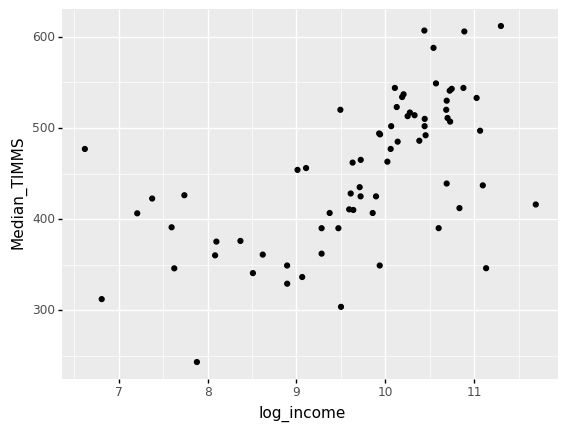

<ggplot: (-9223371910087423408)>

In [22]:
# plot log_income ~ timms dispersion ( # no regression line in order the plot to look the same as the assignment)

ggplot(data=df_timms) +\
    geom_point(mapping=aes(x='log_income', y='Median_TIMMS'))

In [23]:
# append the residuals of the model - will be used later 
df_timms["TIMMS_RESIDUALS"] = timms_res.resid
df_timms.head(5)

,Country Name,log_income,Median_TIMMS,TIMMS_RESIDUALS
0,Argentina,9.85751153801416,406.6525573730469,-50.97590898415035
3,Armenia,9.011393413860638,454.0,31.693559243862182
6,Australia,10.685549555328791,520.0,27.804279720073907
9,Austria,10.699955361911748,511.0,18.20289528638608
12,Azerbaijan,9.723095951374358,465.0,12.982843289694415


In [24]:
# model for df_pirls
model_pirls = smf.ols("Median_PIRLS ~ log_income ", data=df_pirls)
pirls_res = model_pirls.fit()
print(pirls_res.params)
pirls_res.summary()

Intercept     42.61912688056378
log_income   43.912414827091546
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Median_PIRLS   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     55.61
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           2.48e-10
Time:                        00:22:22   Log-Likelihood:                -367.97
No. Observations:                  68   AIC:                             739.9
Df Residuals:                      66   BIC:                             744.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.6191     57.790      0.737      0.463     -72.762     158.000
log_income    43.9124      5.889      7.457      0.000      32.155      55.669
==============================================================================
Omnibus:                       10.020   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.389
Skew:                          -0.951   Prob(JB):                      0.00555
Kurtosis:                       3.226   Cond. No.                         85.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
# exponetiate the log coefficients for better interpretation
print("b1 coefficient exp :", np.exp(43.9124))

b1 coefficient exp : 1.1773701126703415e+19


### Intepretation of the model - model_pirls
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages.\ 
  In our case the model explains the behavior of the data at a 45.7 %  ( not pretty good) 
- Intercept : 42.619, Indicates the mean of the response, Y, when all predictors are equal to 0.
- Coefficient of 1.1773 : means that if the Median_PIRLS variable increases by 1, then the response value will increased by one   and vice versa. 

- Check if Intercept / Coefficients are equal to zero or not \
  p value for intercept : 0.463 < 0.05 - False so we cannot reject the null hypothesis.\
  p value for log_income : 0.000 < 0.05 so we can reject the null hypothesis and assume that it is statistically significant.

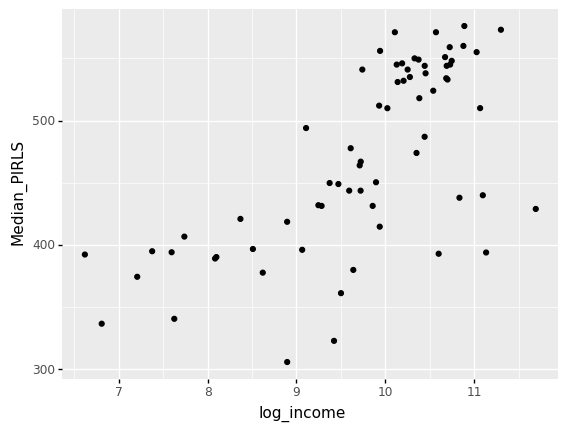

<ggplot: (-9223371910087425824)>

In [26]:
# plot log_income ~ pirls dispersion (# no regression line in order the plot to look the same as the assignment)

ggplot(data=df_pirls) +\
    geom_point(mapping=aes(x='log_income', y='Median_PIRLS'))

We append the residuals of the regression into the original dataframe for later manipulation. 

In [27]:
# will be used later
df_pirls["PIRLS_RESIDUALS"] = pirls_res.resid
df_pirls

,Country Name,log_income,Median_PIRLS,PIRLS_RESIDUALS
0,Argentina,9.85751153801416,431.44354248046875,-44.042720220213994
6,Australia,10.685549555328791,534.0,22.152588390394726
9,Austria,10.699955361911748,533.0,20.51999463580512
12,Azerbaijan,9.723095951374358,467.0,-2.5837497009289336
18,Benin,7.5944653590200275,394.1966857910156,18.086245675187683
...,...,...,...,...
210,Togo,7.207394258154397,374.49041748046875,15.377204113431333
213,Trinidad and Tobago,10.350844738899612,474.0,-23.149714865941633
222,United Arab Emirates,11.09703685361535,440.0,-89.91681254804382
225,United States,10.878599744778276,560.0,39.67528838884027


## Q2: Years of Schooling and Test Scores


In [28]:
# read the BL2013_MF1599_v2.2.dta stata file
school_years = pd.read_stata('Replication Files\Replication Files\DATA\BL2013_MF1599_v2.2.dta')

In [29]:
school_years = school_years.rename(columns={"WBcode": "Country Code"}) 

For the second question we are going to use an additional dataset, the school_years which contains average years of schooling data. First we shall fit a model for the the logged per capita GDP in 2015  as independent variable) and the years of schooling as dependent variable. Afterwards we will use the residuals of this model and we will fit two models using the residuals of the question 1 models for PIRLS and TIMMS regressions with logged GDP.  Linear regression residuals measure the quantity of each datapoint from the regression line we have fitted into the data, naturally residuals describe the error that cannot be explained by the regression line. 

After merging the datasets, technically we apply the same cleaning procedures with question 1, we filter the Series Name column on value condition "GDP per capita, PPP (constant 2011 international $)" since we only want these values. We convert the year column to integer in order to filter and keep only 2010 values. Furthermore we drop the problematic value of ".." in the column 
"2015 [YR2015]" . We append via left join the df_timms and df_pirls dataframes wich are already cleaned  on Country Column and befoe we apply the requested regression we drop the na values. 

In [30]:
# create df for question 
dfq2 = pd.merge(wdi_data, school_years, on = "Country Code", how = "inner")

In [31]:
dfq2.shape

(5538, 24)

In [32]:
# same basic cleaning with Q1 

# filter GDP per capita, PPP (constant 2011 international $)
dfq2 = dfq2.loc[dfq2["Series Name"] == "GDP per capita, PPP (constant 2011 international $)"]

In [33]:
# convert the year to integer
dfq2["year"] = dfq2["year"].astype('int')

In [34]:
dfq2["year"].unique()

array([1950, 1955, 1960, 1965, 1970, 1975, 1980, 1985, 1990, 1995, 2000,
       2005, 2010])

In [35]:
# filter the year for using observation of 2010
dfq2 = dfq2.loc[dfq2["year"] == 2010]

In [36]:
dfq2.isna().sum()

Country Name     0
Country Code     0
Series Name      0
Series Code      0
2015 [YR2015]    0
BLcode           0
country          0
year             0
sex              0
agefrom          0
ageto            0
lu               0
lp               0
lpc              0
ls               0
lsc              0
lh               0
lhc              0
yr_sch           0
yr_sch_pri       0
yr_sch_sec       0
yr_sch_ter       0
pop              0
region_code      0
dtype: int64

In [37]:
# find the error
dfq2["2015 [YR2015]"].unique()

array(['1809.01648820483', '10971.2925173789', '13724.723852895',
       '19101.2973920688', '8195.93364956571', '43719.5021648696',
       '44353.8752139122', '43926.474036316', '3132.56754015214',
       '16460.1541131793', '41722.9218634283', '8061.33183075712',
       '1987.16714645212', '6531.51939817124', '15356.457617167',
       '14666.0181678984', '74600.1642971982', '17000.1672471067',
       '748.41527127932', '3290.95245385442', '3289.06454559229',
       '43149.4758370305', '626.410872523764', '22536.6176878913',
       '13569.8915267324', '12985.3831345266', '750.088577159449',
       '5542.89298198573', '14914.2067461734', '3241.61205578957',
       '20759.0481463138', '..', '30549.1009696787', '30605.4205211471',
       '45458.697148831', '13371.524988334', '10749.1288738874',
       '10095.6101677121', '7845.15757525445', '27549.5813697378',
       '8477.6447332114', '38941.7636030551', '37765.7508688631',
       '16836.6059057727', '1568.02291355603', '43937.947131727

In [38]:
# drop ".."
dfq2.drop(dfq2[dfq2["2015 [YR2015]"] == ".."].index, inplace = True)

In [39]:
# convert "2015 [YR2015]" and yr_sch float 
dfq2 = dfq2.astype({"2015 [YR2015]": float, "yr_sch" : float})

In [40]:
# apply log in the income column 
dfq2["2015 [YR2015]"] = np.log(dfq2["2015 [YR2015]"]) 

In [41]:
# rename column 
dfq2 = dfq2.rename(columns={"2015 [YR2015]": "log_income"})

In [42]:
# subset dfq2
dfq2 = dfq2[["Country Name","log_income","yr_sch"]]

In [43]:
# left join with df_timms
dfq2 = pd.merge(dfq2, df_timms[["Country Name", "Median_TIMMS"]],
                on = "Country Name", how = "left")

In [44]:
# left join with df_pirls
dfq2 = pd.merge(dfq2, df_pirls[["Country Name", "Median_PIRLS"]],
                on = "Country Name", how = "left")

In [45]:
# check NAs  
dfq2.isna().sum()

Country Name     0
log_income       0
yr_sch           0
Median_TIMMS    73
Median_PIRLS    75
dtype: int64

In [46]:
dfq2.shape

(138, 5)

In [47]:
dfq2 = dfq2.dropna(subset=['Median_TIMMS', 'Median_PIRLS'], how='all')

In [48]:
dfq2.shape

(72, 5)

In [49]:
# regression for yr_sch ~ log_income

model2 = smf.ols("yr_sch ~ log_income", data=dfq2)
model2_res = model2.fit()
print(model2_res.params)
model2_res.summary()

Intercept    -10.13097434230044
log_income   1.9593883725516936
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yr_sch   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     110.6
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           4.74e-16
Time:                        00:22:38   Log-Likelihood:                -138.89
No. Observations:                  72   AIC:                             281.8
Df Residuals:                      70   BIC:                             286.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1310      1.838     -5.512      0.000     -13.797      -6.465
log_income     1.9594      0.186     10.515      0.000       1.588       2.331
==============================================================================
Omnibus:                        8.402   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.855
Skew:                          -0.724   Prob(JB):                       0.0197
Kurtosis:                       3.723   Cond. No.                         92.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Intepretation of the model - model_pirls
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages.\ 
  In our case the model explains the behavior of the data at a 61.2 %  ( good but it can be improved) 
- Intercept : -10.131, Indicates the mean of the response, Y, when all predictors are equal to 0.\
It has no practical mean since the income cannot take negative values. 
- Coefficient of 1.959 : means that if the yr_sch variable increases by 1, then the response value will increased by one and\     vice versa. 

- Check if Intercept / Coefficients are equal to zero or not \
  p value for intercept : 0.000 < 0.05 - so we cannot reject the null hypothesis and assume it is statistically significant.
  p value for log_income : 0.000 < 0.05 so we can reject the null hypothesis and assume that it is statistically significant.

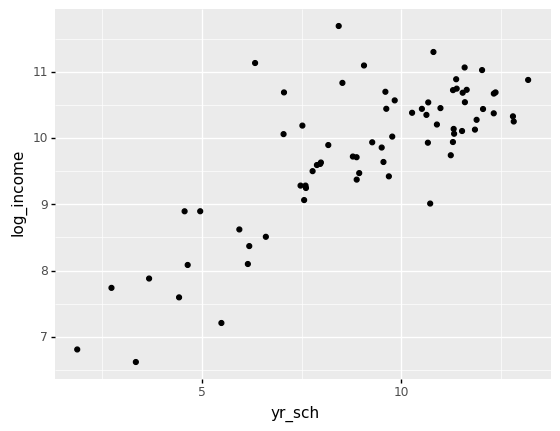

<ggplot: (-9223371910085797508)>

In [50]:
# plot log_income ~ yr_sch dispersion ( # no regression line in order the plot to look the same as the assignment)
ggplot(data=dfq2) +\
    geom_point(mapping=aes(x='yr_sch', y='log_income'))
# not reqquested 

From the above plot we can see a patern of monotonic and linear effect even though there are some outliers.\
It is clear that the more the years of schooling the logged GDP per capita is increasing. 

In [51]:
# append yr_sch_RESIDUALS in the original dataaframe 
dfq2["yr_sch_RESIDUALS"] = model2_res.resid
dfq2.head(10)

,Country Name,log_income,yr_sch,Median_TIMMS,Median_PIRLS,yr_sch_RESIDUALS
3,Argentina,9.85751153801416,9.51037883758545,406.6525573730469,431.44354248046875,0.32665969000678174
4,Armenia,9.011393413860638,10.726531028747559,454.0,NaN,3.2006858954405537
5,Australia,10.685549555328791,11.541207313537598,520.0,534.0,0.7350401028018858
6,Austria,10.699955361911748,9.60340404510498,511.0,533.0,-1.2309897355466077
7,Bahrain,10.690272470518785,7.060834884643555,439.0,NaN,-3.754586351199979
12,Benin,7.5944653590200275,4.430164337158203,390.9491882324219,394.1966857910156,-0.3193684407518216
14,Botswana,9.639291356221529,9.554915428161621,410.0,380.0,0.7987743674435528
15,Brazil,9.59328840742963,7.886318206787109,410.6283874511719,443.6954040527344,-0.7796852109650239
17,Bulgaria,9.74097846105506,11.242852210998535,NaN,541.0,2.2874666194312034
18,Burundi,6.617957999428683,3.3464810848236084,476.97845458984375,392.37420654296875,0.510305473008021


In [52]:
# df_timms
# df_pirls
# dfq2 

In [53]:
print(df_timms.shape)
df_timms.head(1)

(71, 4)


,Country Name,log_income,Median_TIMMS,TIMMS_RESIDUALS
0,Argentina,9.85751153801416,406.6525573730469,-50.97590898415035


In [54]:
print(df_pirls.shape)
df_pirls.head(1)

(68, 4)


,Country Name,log_income,Median_PIRLS,PIRLS_RESIDUALS
0,Argentina,9.85751153801416,431.44354248046875,-44.042720220213994


In [55]:
print(dfq2.shape)
dfq2.head(1)

(72, 6)


,Country Name,log_income,yr_sch,Median_TIMMS,Median_PIRLS,yr_sch_RESIDUALS
3,Argentina,9.85751153801416,9.51037883758545,406.6525573730469,431.44354248046875,0.32665969000678174


In [56]:
# dataframe with residuals for regression yr_sch_RESIDUALS ~ TIMMS_RESIDUALS
df_res1 = pd.merge(df_timms[["Country Name","TIMMS_RESIDUALS"]],
                  dfq2[["Country Name","yr_sch_RESIDUALS"]], how = "inner" )
print(df_res1.shape)
df_res1.head(5)

(65, 3)


,Country Name,TIMMS_RESIDUALS,yr_sch_RESIDUALS
0,Argentina,-50.97590898415035,0.32665969000678174
1,Armenia,31.693559243862182,3.2006858954405537
2,Australia,27.804279720073907,0.7350401028018858
3,Austria,18.20289528638608,-1.2309897355466077
4,Bahrain,-53.39288297682435,-3.754586351199979


In [57]:
# dataframe with residuals for regression yr_sch_RESIDUALS ~ PIRLS_RESIDUALS

df_res2 = pd.merge(df_pirls[["Country Name","PIRLS_RESIDUALS"]],
                  dfq2[["Country Name","yr_sch_RESIDUALS"]], how = "inner" )
print(df_res2.shape)
df_res2.head(5)

(63, 3)


,Country Name,PIRLS_RESIDUALS,yr_sch_RESIDUALS
0,Argentina,-44.042720220213994,0.32665969000678174
1,Australia,22.152588390394726,0.7350401028018858
2,Austria,20.51999463580512,-1.2309897355466077
3,Benin,18.086245675187683,-0.3193684407518216
4,Botswana,-85.90368755416142,0.7987743674435528


In [58]:
# model3 regression  ~ yr_sch_RESIDUALS 

model3 = smf.ols("TIMMS_RESIDUALS ~ yr_sch_RESIDUALS ", data=df_res1)
model3_res = model3.fit()
print(model3_res.params)
model3_res.summary()

Intercept          1.4155400414077937
yr_sch_RESIDUALS   21.585636670924025
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        TIMMS_RESIDUALS   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     29.30
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           1.03e-06
Time:                        00:22:44   Log-Likelihood:                -350.69
No. Observations:                  65   AIC:                             705.4
Df Residuals:                      63   BIC:                             709.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.4155      6.734      0.210      0.834     -12.041      14.872
yr_sch_RESIDUALS    21.5856      3.988      5.413      0.000      13.617      29.554
==============================================================================
Omnibus:                        2.751   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.253   Jarque-Bera (JB):                1.934
Skew:                           0.370   Prob(JB):                        0.380
Kurtosis:                       3.407   Cond. No.                         1.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Intepretation of the model - model3
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages. 
  In our case the model explains the behavior of the data at a 31.7 %  ( bad) 
- Intercept : 1.415, Indicates the mean of the response, Y, when all predictors are equal to 0.
- Coefficient of 21.585 : means that if the TIMMS_RESIDUALS variable increases by 1, then the response value will increased by one and\     vice versa. 

- Check if Intercept / Coefficients are equal to zero or not \
  p value for intercept : 0.834 < 0.05 - False so we cannot reject the null hypothesis and assume it is not  statistically       significant.
  p value for yr_sch_RESIDUALS : 0.000 < 0.05 so we can reject the null hypothesis and assume that it is statistically           significant.

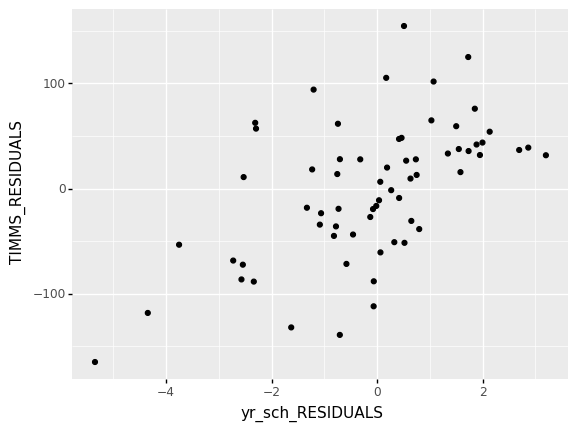

<ggplot: (-9223371910085841780)>

In [59]:
# plot regression TIMMS_RESIDUALS ~ yr_sch_RESIDUALS (#no regression line in order the plot to look the same as the assignment)
ggplot(data=df_res1) +\
    geom_point(mapping=aes(x='yr_sch_RESIDUALS', y='TIMMS_RESIDUALS'))

In [60]:
# model4 regression PIRLS_RESIDUALS ~ yr_sch_RESIDUALS

model4 = smf.ols("yr_sch_RESIDUALS ~ PIRLS_RESIDUALS", data=df_res2)
model4_res = model4.fit()
model4_res.params

Intercept         0.0031732203010365057
PIRLS_RESIDUALS    0.017658360914486793
dtype: float64

In [61]:
model4_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       yr_sch_RESIDUALS   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     33.96
Date:                Sun, 04 Apr 2021   Prob (F-statistic):           2.27e-07
Time:                        00:22:47   Log-Likelihood:                -104.46
No. Observations:                  63   AIC:                             212.9
Df Residuals:                      61   BIC:                             217.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0032      0.163      0.020      0.985      -0.322       0.328
PIRLS_RESIDUALS     0.0177      0.003      5.828      0.000       0.012       0.024
==============================================================================
Omnibus:                        3.045   Durbin-Watson:                   1.799
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.247
Skew:                          -0.291   Prob(JB):                        0.325
Kurtosis:                       3.719   Cond. No.                         53.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Intepretation of the model - model4
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages. 
  In our case the model explains the behavior of the data at a 35.8 %  ( bad) 
- Intercept : 0.003, Indicates the mean of the response, Y, when all predictors are equal to 0.
- Coefficient of 0.0177 : means that if the yr_sch_RESIDUALS variable increases by 1, then the response value will increased by one and\     vice versa. 

- Check if Intercept / Coefficients are equal to zero or not \
  p value for intercept : 0.834 < 0.05 - False so we cannot reject the null hypothesis and assume it is not  statistically       significant.
  p value for yr_sch_RESIDUALS : 0.000 < 0.05 so we can reject the null hypothesis and assume that it is statistically           significant.

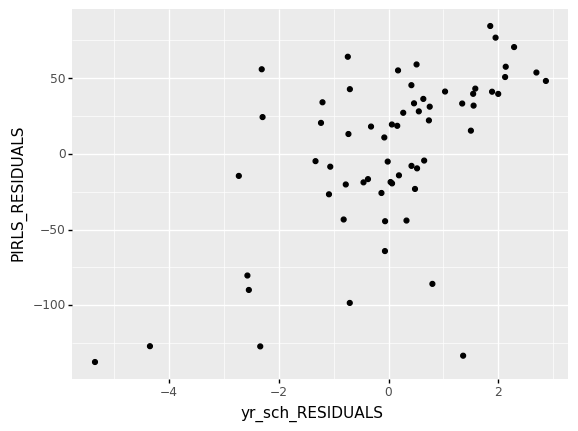

<ggplot: (-9223371910085724484)>

In [62]:
# plot regression PIRLS_RESIDUALS ~ yr_sch_RESIDUALS
ggplot(data=df_res2) +\
    geom_point(mapping=aes(x='yr_sch_RESIDUALS', y='PIRLS_RESIDUALS'))

## Q3: Compare New and Previous Estimates

In [63]:
# read the BL2013_MF1599_v2.2.dta stata file
learning_est = pd.read_stata("Replication Files\Replication Files\DATA\HLO Panel Data (mean, thresh) - Jan 2018.dta")

In [64]:
learning_est = learning_est.rename(columns={"country": "Country Name", "cntabb" : "Country Code"})
learning_est.head(5)

,Country Name,idcntry,Country Code,year,HLO,low_threshold
0,"Abu Dhabi, UAE",7842,ADA,1965,NaN,NaN
1,"Abu Dhabi, UAE",7842,ADA,1970,NaN,NaN
2,"Abu Dhabi, UAE",7842,ADA,1975,NaN,NaN
3,"Abu Dhabi, UAE",7842,ADA,1980,NaN,NaN
4,"Abu Dhabi, UAE",7842,ADA,1985,NaN,NaN


For Question 3 we load the learning_est dataframe which contains  learning outcome estimates from the World Bank.\
The basic cleaning procedures will be to check for na values and drop them. 
Then we will implement a group by operation by year and country code in d since we want to take the latest year for each country. 

In [70]:
learning_est.dtypes

Country Name      object
idcntry            int32
Country Code      object
year               int16
HLO              float32
low_threshold    float32
dtype: object

In [86]:
# check the years unique values 
year = learning_est["year"].unique()
year

array([2010, 2015, 2000, 2005, 1995, 1970, 1975, 1980, 1985, 1990],
      dtype=int16)

In [87]:
# check the country unique values 
country = learning_est["Country Code"].unique()
country

array(['ADA', 'ALB', 'DZA', 'ARG', 'ARB', 'ARM', 'AUS', 'AUT', 'AZE',
       'BHR', 'BSQ', 'BEL', 'BFL', 'BFR', 'BEN', 'BOL', 'BIH', 'BWA',
       'BRA', 'BGR', 'BFA', 'BDI', 'CMR', 'CAN', 'CAB', 'CBC', 'CNS',
       'COT', 'CQU', 'TCD', 'CHL', 'CHN', 'TWN', 'COL', 'COM', 'CRI',
       'HRV', 'CUB', 'CYP', 'CZE', 'CIV', 'COD', 'DNK', 'DOM', 'ADU',
       'ECU', 'EGY', 'SLV', 'ENG', 'EST', 'FIN', 'FRA', 'GAB', 'GMB',
       'GEO', 'DEU', 'GHA', 'GRC', 'GTM', 'HND', 'HKG', 'HUN', 'ISL',
       'IND', 'UIN', 'IDN', 'IRN', 'IRL', 'ISR', 'ITA', 'JPN', 'JOR',
       'KAZ', 'KEN', 'KOR', 'KWT', 'KGZ', 'LVA', 'LBN', 'LSO', 'LBR',
       'LIE', 'LTU', 'LUX', 'MAC', 'MKD', 'MDG', 'MWI', 'MYS', 'MLI',
       'MLT', 'QUC', 'MUS', 'MEX', 'NMX', 'UMN', 'MDA', 'MNG', 'MNE',
       'MAR', 'MOZ', 'NAM', 'NPL', 'NLD', 'NZL', 'NIC', 'NER', 'NGA',
       'US4', 'NIR', 'NOR', 'PSE', 'OMN', 'PAK', 'PAN', 'PRY', 'PER',
       'PHL', 'POL', 'PRT', 'PRI', 'QAT', 'ROU', 'RUS', 'SAU', 'SCO',
       'SEN', 'SRB',

In [88]:
learning_est.isna().sum()

Country Name     0
idcntry          0
Country Code     0
year             0
HLO              0
low_threshold    0
dtype: int64

In [89]:
learning_est = learning_est.dropna()

In [92]:
learning_est.isna().sum()

Country Name     0
idcntry          0
Country Code     0
year             0
HLO              0
low_threshold    0
dtype: int64

In [93]:
dfq3 = learning_est[["Country Code","year"]]

In [94]:
# sort the dfq3 by year in order to get the latest and by country in order to group the data 
dfq3 = learning_est.sort_values(by=["year","Country Code"], ascending = [False,True])

In [95]:
# remove the duplicate rows
dfq3.drop_duplicates(subset = ["Country Code"], inplace = True)

In [96]:
dfq3.head(5)

,Country Name,idcntry,Country Code,year,HLO,low_threshold
10,"Abu Dhabi, UAE",7842,ADA,2015,437.07000732421875,73.75
526,"Dubai, UAE",7841,ADU,2015,510.0899963378906,91.44000244140625
21,Albania,8,ALB,2015,436.7300109863281,70.6500015258789
54,"Argentina, Buenos Aires",974,ARB,2015,414.19000244140625,67.75
1760,United Arab Emirates,784,ARE,2015,460.489990234375,80.83999633789062


In [97]:
dfq3 = pd.merge(dfq3, country_scores, on = "Country Code", how = "inner")
print(dfq3.shape)
dfq3.head(5)

(77, 11)


,Country Name,idcntry,Country Code,year,HLO,low_threshold,Country,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,United Arab Emirates,784,ARE,2015,460.489990234375,80.83999633789062,U.A.E.,64.0,63.9823112487793,437.0,440.0
1,Argentina,32,ARG,2015,429.3800048828125,70.86000061035156,Argentina,51.0,66.0,406.6525573730469,431.44354248046875
2,Australia,36,AUS,2015,509.2200012207031,91.52999877929688,Australia,90.0,92.93280029296875,520.0,534.0
3,Austria,40,AUT,2015,519.5399780273438,88.51000213623047,Austria,95.30219268798828,97.10411071777344,511.0,533.0
4,Bulgaria,100,BGR,2015,490.6700134277344,78.87999725341797,Bulgaria,NaN,93.0484390258789,NaN,541.0


In [98]:
# rename columns 
dfq3 = dfq3.rename(columns={"Percent Above Math Benchmark (400 on TIMSS Scale)": "Percent_400_TIMMS", 
                            "Percent Above Reading Benchmark (400 on PIRLS Scale)" : "Percent_400_PIRLS"})
# subset 
dfq3 = dfq3[["Country Code","Country","Percent_400_TIMMS","Percent_400_PIRLS","low_threshold"]]
dfq3.head(10)

,Country Code,Country,Percent_400_TIMMS,Percent_400_PIRLS,low_threshold
0,ARE,U.A.E.,64.0,63.9823112487793,80.83999633789062
1,ARG,Argentina,51.0,66.0,70.86000061035156
2,AUS,Australia,90.0,92.93280029296875,91.52999877929688
3,AUT,Austria,95.30219268798828,97.10411071777344,88.51000213623047
4,BGR,Bulgaria,NaN,93.0484390258789,78.87999725341797
5,BHR,Bahrain,67.0,NaN,80.5999984741211
6,BRA,Brazil,59.0,72.0,63.310001373291016
7,BWA,Botswana,NaN,NaN,64.3499984741211
8,CAN,Canada,NaN,97.75077819824219,96.0999984741211
9,CHL,Chile,81.0,93.0,76.33000183105469


In [99]:
dfq3.dtypes

Country Code          object
Country               object
Percent_400_TIMMS    float64
Percent_400_PIRLS    float64
low_threshold        float32
dtype: object

In [100]:
# convert to float before the test
dfq3 = dfq3.astype({"Percent_400_TIMMS": float, "Percent_400_PIRLS" : float, "low_threshold" : float})

### Spearman test 1

In [101]:
# Spearman test TIMSS
X = dfq3[["Percent_400_TIMMS"]]
Y = dfq3[["low_threshold"]]
print('Spearman', stats.spearmanr(X, Y, nan_policy='omit'))

Spearman SpearmanrResult(correlation=0.8973790562032016, pvalue=1.687973764124364e-25)


### Spearman test 2

In [102]:
# Spearman test PIRLS
X1 = dfq3[["Percent_400_PIRLS"]]
Y1 = dfq3[["low_threshold"]]
print('Spearman', stats.spearmanr(X1, Y1, nan_policy='omit'))

Spearman SpearmanrResult(correlation=0.9045173418249433, pvalue=5.290584772193416e-25)


We implement Spearman correlation test in order to check the connection of strength through the two variables. 
Like Pearson test, Spearman is used to describe correlation but it is better used for ordinal data, while Pearson's correlation assesses linear relationships, Spearman's correlation assesses monotonic relationships
If the relationship is not linear, but is nevertheless monotonic, then a different correlation coefficient, Spearman's rank correlation coefficient may be more appropriate.
If there are no repeated data values ( in ourcase we removed them), a perfect Spearman correlation of +1 or −1 occurs when each of the variables is a perfect monotone function of the other. Bothe test indicate strong monotonic relationship between the variables Percent_400_TIMMS and Percent_400_PIRLS with low_threshold respectively. 

From the below plots, the monotonic relationship is  clear as the WB estimates increasing the Percent_400_TIMMS and 
Percent_400_PIRLS variable is increasing for the majority of all countries. We can assume also linear relationship from the plots but further checking is needed to be sure.

C:\Users\svret\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


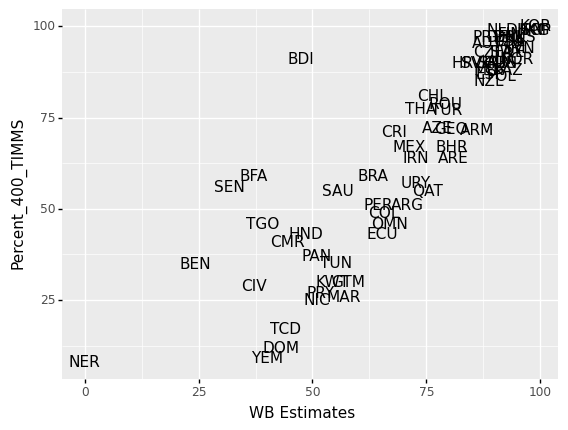

<ggplot: (-9223371910085720024)>

In [103]:
# plot1 
ggplot(data=dfq3, mapping=aes(x='low_threshold', y='Percent_400_TIMMS')) +\
    labs(x='WB Estimates', y='Percent_400_TIMMS') +\
    geom_text(mapping=aes(label='Country Code'), na_rm=True)

C:\Users\svret\Anaconda3\lib\site-packages\plotnine\utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


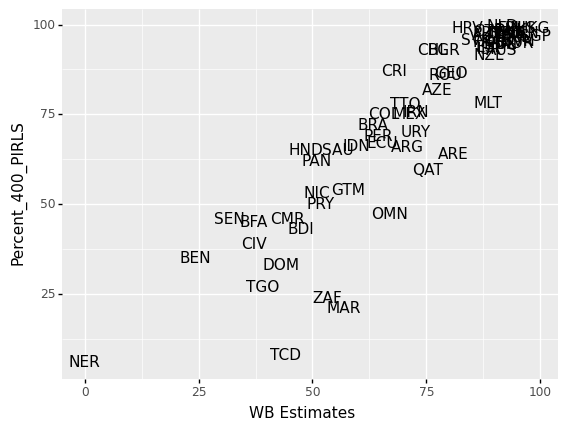

<ggplot: (-9223371910085597800)>

In [104]:
# plot 2 
ggplot(data=dfq3, mapping=aes(x='low_threshold', y='Percent_400_PIRLS')) +\
    labs(x='WB Estimates', y='Percent_400_PIRLS') +\
    geom_text(mapping=aes(label='Country Code'), na_rm=True)

## Q4: Skills Intensity

In [105]:
# read file usa_00001.csv.gz
file_usa = pd.read_csv(r"usa_00001.csv\usa_00001.csv")
file_usa.head(1)

,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND
0,2000,200004,1,600.0,2000000000014,17,1,1,618.0,8,81,1,10,3130,797


In [106]:
# read file cw_ind2000_ind1990ddx.dta
cw_ind = pd.read_stata("Replication Files\Replication Files\DATA\cw_ind2000_ind1990ddx.dta")
cw_ind.head(1)

,ind2000,ind1990ddx,weight
0,17,10,0.9940157095672427


In [107]:
# read file BACI_HS17_Y2018_V202001.csv.gz
baci = pd.read_csv(r"rosetta_stone_assignment_data 2 (1)\BACI_HS17_Y2018_V202001.csv\BACI_HS17_Y2018_V202001.csv")
baci.head(1)

,t,i,j,k,v,q
0,2018,4,24,845420,101.397,26.0


In [108]:
# read file cw_hs6_sic87dd.dta
cwhs6 = pd.read_stata("Replication Files\Replication Files\DATA\cw_hs6_sic87dd.dta")
cwhs6.head(1)

,hs6,sic87dd,share,weights_method
0,"10,110.0",272.0,1.0,no weights needed


In [109]:
# read file cw_sic87_ind1990ddx.dta
cwsic87 = pd.read_stata("Replication Files\Replication Files\DATA\cw_sic87_ind1990ddx.dta")
cwsic87.head(1)

,ind1990ddx,sic87
0,10,111


In [110]:
# read file country_codes
country_codes = pd.read_csv(r"rosetta_stone_assignment_data 2 (1)\country_codes_V202001.csv\country_codes_V202001.csv")
country_codes.head(1)

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG


Above, after reading carefully the exercise question 4 we have already installed the packages we are going to use for the implementation. The goal is to run the following regressions. (taken from the assignment documntation) 

- log(𝑉𝑐𝑖)∼TIMSS𝑐/1000:college𝑖+𝑖+𝑐
 
- log(𝑉𝑐𝑖)∼PIRLS𝑐/1000:college𝑖+𝑖+𝑐
 
- log(𝑉𝑐𝑖)∼TIMSS𝑐/1000:highschool𝑖+𝑖+𝑐
 
- log(𝑉𝑐𝑖)∼PIRLS𝑐/1000:highschool𝑖+𝑖+𝑐

In the above:

- 𝑉𝑐𝑖  is the value of export trade for each country ( 𝑐 ) and industry ( 𝑖 )

- TIMMS𝑐  is the TIMMS score for country  𝑐 , which we divide by 1000 to get a more readable result

- PIRLS𝑐  is the PIRLS score for country  𝑐 , which we similarly divide by 1000

- college𝑖  is the portion of employees in industry  𝑖  with at least a college degree

- highschool  is the portion of employees in industry  𝑖  with at least a high school degree


The goal as above said is to fit four linear models and describe its R2 and Intercept. In order to get there we have to to a lot of data manipulation , multiple files are used and joined with each other in order to construct the final dataset. The trick here is to understand the mapping between the various files. When the final dataset is constructed, then we use the same procedure like question 1 thus we split the dataframe into two minor dataframes each one for PIRLS and TIMMS metric respectively and then after a little more data manipulation we can fit the four requested models. 

First of all we are using the file_usa in order to find college graduates and highschool graduates. 
The distinction is that college graduates have at least 10 years of school education while high school graduates have at least 6. After this basic filtering we have the college_grad and the hschool_grad subsets. 

In [118]:
# file_usa -identify college graduates, using the rule that they have at least 10 years of education
# YEAR	SAMPLE	SERIAL	HHWT	CLUSTER	STRATA	GQ	PERNUM	PERWT	EDUC	EDUCD	EMPSTAT	EMPSTATD	OCC2010	IND

# filter EDUC greater or equal to 10 
college_grad = file_usa.loc[(file_usa["EDUC"] >= 10)]
print("Values of college_grad: ",college_grad["EDUC"].unique())
print(" ")
print(college_grad.head(5))
print(college_grad.shape)

print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# filter EDUC greater or equal to 6 

hschool_grad = file_usa.loc[(file_usa["EDUC"] >= 6)]

print("Values of hschool_grad: ",hschool_grad["EDUC"].unique())
print("")
print(hschool_grad.head(5))
print(hschool_grad.shape)


Values of college_grad:  [10 11]
 
    YEAR  SAMPLE  SERIAL  HHWT        CLUSTER  STRATA  GQ  PERNUM  PERWT  \
8   2000  200004       5 600.0  2000000000054      12   1       1  603.0   
13  2000  200004       7 600.0  2000000000074       6   1       1  628.0   
14  2000  200004       7 600.0  2000000000074       6   1       2  708.0   
20  2000  200004      11 600.0  2000000000114      17   1       2  518.0   
21  2000  200004      12 200.0  2000000000124      11   1       1  214.0   

    EDUC  EDUCD  EMPSTAT  EMPSTATD  OCC2010  IND  
8     10    101        3        30      700  959  
13    10    101        1        10     3300  819  
14    11    114        1        10     2600  657  
20    11    116        1        10     2010  837  
21    10    101        3        30       30  668  
(69972, 15)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Afterwards, we group the data by column IND which stands for Industry and create  USA_BY_IND, COLLEGE_BY_IND, HSCHOOL_BY_IND
in order to create three groupped dataframes. One for the general population of USA , one for the college graduates and one for the highschool graduates.

In [119]:
# group by operation USA_BY_IND
USA_BY_IND = file_usa[["IND","PERWT"]].groupby(["IND"]).sum()
USA_BY_IND = USA_BY_IND.rename(columns={"PERWT" : "USA_PERWT"})
USA_BY_IND.head(5)

,USA_PERWT
IND,
0,"108,371,644.0"
17,"1,391,515.0"
18,"723,084.0"
19,"32,080.0"
27,"147,320.0"


In [120]:
# group by operation COLLEGE_BY_IND
COLLEGE_BY_IND = college_grad[["IND","PERWT"]].groupby(["IND"]).sum()
COLLEGE_BY_IND = COLLEGE_BY_IND.rename(columns={"PERWT" : "COLLEGE_PERWT"})
COLLEGE_BY_IND.head(5)

,COLLEGE_PERWT
IND,
0,"5,117,532.0"
17,"133,389.0"
18,"70,935.0"
19,"10,095.0"
27,"7,917.0"


In [121]:
# group by operation HSCHOOL_BY_IND
HSCHOOL_BY_IND = hschool_grad[["IND","PERWT"]].groupby(["IND"]).sum()
HSCHOOL_BY_IND = HSCHOOL_BY_IND.rename(columns={"PERWT" : "HSCHOOL_PERWT"})
HSCHOOL_BY_IND.head(5)

,HSCHOOL_PERWT
IND,
0,"28,314,555.0"
17,"806,904.0"
18,"516,534.0"
19,"29,645.0"
27,"112,982.0"


In [122]:
# weighted average calculation of college_grad and hschool_grad for each industry # 

# Note that will have to use the PERWT attribute,
# which shows how many persons in the US population are represented by a given person in the data. 

# Create a DataFrame that contains the industry, the weighted average for college graduates,
# and the weighted average for high school graduates.

As assignment documentation says , we want weighted average calculation of college_grad and hschool_grad for each industry.
We will join the above grouped dataframes and then we will construct two new columns the weighted averages for each group by dividing with the general population. New columns are named COLLEGE_WAVG and HSCHOOL_WAVG where "W" stands for weighted.

In [123]:
# join (on index)
dfq4 = COLLEGE_BY_IND.join(HSCHOOL_BY_IND)
dfq4.head(5)

,COLLEGE_PERWT,HSCHOOL_PERWT
IND,,
0,"5,117,532.0","28,314,555.0"
17,"133,389.0","806,904.0"
18,"70,935.0","516,534.0"
19,"10,095.0","29,645.0"
27,"7,917.0","112,982.0"


In [124]:
# join (on index)
dfq4 = dfq4.join(USA_BY_IND)
print(dfq4.shape)
dfq4.head(5)

(265, 3)


,COLLEGE_PERWT,HSCHOOL_PERWT,USA_PERWT
IND,,,
0,"5,117,532.0","28,314,555.0","108,371,644.0"
17,"133,389.0","806,904.0","1,391,515.0"
18,"70,935.0","516,534.0","723,084.0"
19,"10,095.0","29,645.0","32,080.0"
27,"7,917.0","112,982.0","147,320.0"


In [125]:
# estimate the COLLEGE_WAVG
dfq4[["COLLEGE_WAVG"]] = dfq4["COLLEGE_PERWT"] / dfq4["USA_PERWT"]
dfq4.head(5)

,COLLEGE_PERWT,HSCHOOL_PERWT,USA_PERWT,COLLEGE_WAVG
IND,,,,
0,"5,117,532.0","28,314,555.0","108,371,644.0",0.04722205745997542
17,"133,389.0","806,904.0","1,391,515.0",0.09585883012400154
18,"70,935.0","516,534.0","723,084.0",0.0981006356108004
19,"10,095.0","29,645.0","32,080.0",0.31468204488778057
27,"7,917.0","112,982.0","147,320.0",0.05374015748031496


In [126]:
# estimate the HSCHOOL_WAVG
dfq4[["HSCHOOL_WAVG"]] = dfq4["HSCHOOL_PERWT"] / dfq4["USA_PERWT"]
dfq4.head(5)

,COLLEGE_PERWT,HSCHOOL_PERWT,USA_PERWT,COLLEGE_WAVG,HSCHOOL_WAVG
IND,,,,,
0,"5,117,532.0","28,314,555.0","108,371,644.0",0.04722205745997542,0.2612727273935237
17,"133,389.0","806,904.0","1,391,515.0",0.09585883012400154,0.5798744533835424
18,"70,935.0","516,534.0","723,084.0",0.0981006356108004,0.7143485404185406
19,"10,095.0","29,645.0","32,080.0",0.31468204488778057,0.9240960099750624
27,"7,917.0","112,982.0","147,320.0",0.05374015748031496,0.766915557969047


In [127]:
# rounding and 
dfq4[['COLLEGE_PERWT','HSCHOOL_PERWT',"USA_PERWT", "COLLEGE_WAVG", "HSCHOOL_WAVG"]] = dfq4[['COLLEGE_PERWT','HSCHOOL_PERWT',"USA_PERWT", "COLLEGE_WAVG", "HSCHOOL_WAVG"]].apply(lambda x: pd.Series.round(x, 2))


With the new two columns we create the skills_intensity_industry as documentation instructed.

In [128]:
# define skills_intensity_industry with only weighted averages
skills_intensity_industry = dfq4[["COLLEGE_WAVG","HSCHOOL_WAVG"]]
skills_intensity_industry

,COLLEGE_WAVG,HSCHOOL_WAVG
IND,,
0,0.05,0.26
17,0.1,0.58
18,0.1,0.71
19,0.31,0.92
27,0.05,0.77
...,...,...
977,0.2,0.99
978,0.2,0.9
979,0.31,0.97


In [129]:
# The cw_ind2000_ind1990ddx.dta file maps the industry codes of 2000 to those of 1990, 
# with a weight to account for the differences in the ten years.

# use that file to reweight the weighted averages in skills_intensity_industry with the corresponding weight in each mapping.

# The files beginning with cw_ are crosswalk files, and they come from David Dorn's web site.

In [130]:
cw_ind.head(3)

,ind2000,ind1990ddx,weight
0,17,10,0.9940157095672427
1,17,31,0.0026368023875066957
2,17,121,0.0017403815014145902


We set the ind2000 as df INDEX because the skills_intensity_industry is indexed in the IND column and we want to apply join operation. 

In [131]:
# set ind2000 as index # 
cw_ind = cw_ind.set_index("ind2000")
cw_ind.head(3)

,ind1990ddx,weight
ind2000,,
17,10,0.9940157095672427
17,31,0.0026368023875066957
17,121,0.0017403815014145902


In [132]:
# merge on index
dfq4a = pd.merge(skills_intensity_industry, cw_ind, left_index=True, right_index=True)
print(dfq4a.shape)
dfq4a.head(5)

(711, 4)


,COLLEGE_WAVG,HSCHOOL_WAVG,ind1990ddx,weight
17,0.1,0.58,10,0.9940157095672427
17,0.1,0.58,31,0.0026368023875066957
17,0.1,0.58,121,0.0017403815014145902
17,0.1,0.58,561,0.001607106543835987
18,0.1,0.71,11,0.9909066765912076


After the join we are going to recalcuate the weighted averages using the weight of the cw_ind file.
Two new columns are constructed named R_COLLEGE_WAVG and R_HSCHOOL_WAVG where "R" stands as "Recalculated".

In [133]:
# recalculate the weighted average

dfq4a["R_COLLEGE_WAVG"] = dfq4a["COLLEGE_WAVG"] *  dfq4a["weight"]
dfq4a["R_HSCHOOL_WAVG"] = dfq4a["HSCHOOL_WAVG"] *  dfq4a["weight"]
dfq4a.head(5)

,COLLEGE_WAVG,HSCHOOL_WAVG,ind1990ddx,weight,R_COLLEGE_WAVG,R_HSCHOOL_WAVG
17,0.1,0.58,10,0.9940157095672427,0.09940157095672428,0.5765291115490008
17,0.1,0.58,31,0.0026368023875066957,0.0002636802387506696,0.0015293453847538834
17,0.1,0.58,121,0.0017403815014145902,0.00017403815014145903,0.0010094212708204623
17,0.1,0.58,561,0.001607106543835987,0.0001607106543835987,0.0009321217954248724
18,0.1,0.71,11,0.9909066765912076,0.09909066765912077,0.7035437403797573


From the above dataframe we select R_COLLEGE_WAVG and R_HSCHOOL_WAVG in order to create the new R_skills_intensity_industry

In [134]:
# group by ind1990ddx R as RECALCULATED (rename the index)

R_skills_intensity_industry = dfq4a.groupby("ind1990ddx")[["R_COLLEGE_WAVG", "R_HSCHOOL_WAVG"]].sum()
R_skills_intensity_industry.index.names = ['R_IND']
R_skills_intensity_industry.head(5)

,R_COLLEGE_WAVG,R_HSCHOOL_WAVG
R_IND,,
10,0.1552447392352932,0.810372378715508
11,0.09909066765912077,0.7035437403797573
20,0.5599054669295882,2.0171567789554943
31,0.34208283671274464,1.0547720631196036
32,0.17192795011409456,0.6444958724790958


Take on the BACI_HS17_Y2018_V202001.csv.gz file. 

That one contains records showing the exports of different countries in 2018 for different industry sectors.

Mapping 

- t: year
- i: exporter (ISO 3-digit country code)
- j: importer (ISO 3-digit country code)
- k: product category (Harmonized System, HS, 6-digit code)
- v: value of the trade flow (in thousands current USD)
- q: quantity (in metric tons)

In [135]:
baci.head(5)

,t,i,j,k,v,q
0,2018,4,24,845420,101.397,26.0
1,2018,4,24,848180,2.328,0.007
2,2018,4,31,570110,1.596,0.037
3,2018,4,32,340319,8.6993309192618,0.113
4,2018,4,32,610910,1.098,0.013


The HS 6-digit code must be mapped to the industry codes we are using in the rest of the data. This can be done in two steps. 

First, with the cw_hs6_sic87dd.dta you can map the HS 6-digit code with Standard Industrial Codes (SIC) SIC87 industry codes.

trade flow = v  

In [136]:
cwhs6.head(5)

,hs6,sic87dd,share,weights_method
0,"10,110.0",272.0,1.0,no weights needed
1,"10,111.0",272.0,1.0,no weights needed
2,"10,119.0",272.0,1.0,no weights needed
3,"10,120.0",272.0,1.0,no weights needed
4,"10,190.0",272.0,1.0,no weights needed


mapping

baci k :  cwhs6 hs6 

In [137]:
# convert to integer for merging
cwhs6['hs6'] = cwhs6['hs6'].astype(int)
cwhs6.dtypes

hs6                  int32
sic87dd            float64
share              float32
weights_method    category
dtype: object

In [138]:
#rename the baci k for merging 
baci = baci.rename(columns={"k": "hs6"}) 

Basic mapping here is "k": "hs6"

In [139]:
dfq4b = pd.merge(baci,cwhs6, on = "hs6", how = "inner")
dfq4b.head(5)

,t,i,j,hs6,v,q,sic87dd,share,weights_method
0,2018,4,24,845420,101.397,26.0,"3,321.0",0.6364262104034424,trade-based
1,2018,4,24,845420,101.397,26.0,"3,559.0",0.3635737895965576,trade-based
2,2018,36,288,845420,16.3849457296731,0.177,"3,321.0",0.6364262104034424,trade-based
3,2018,36,288,845420,16.3849457296731,0.177,"3,559.0",0.3635737895965576,trade-based
4,2018,36,360,845420,7.109,0.017,"3,321.0",0.6364262104034424,trade-based


In [140]:
# adjust the value of the trade flow of the BACI file with the share column of cw_hs6_sic87dd.dta

In [141]:
# estimate R_TRADE_FLOW
dfq4b[["R_TRADE_FLOW"]] = dfq4b["v"] * dfq4b["share"]
dfq4b.head(5)

,t,i,j,hs6,v,q,sic87dd,share,weights_method,R_TRADE_FLOW
0,2018,4,24,845420,101.397,26.0,"3,321.0",0.6364262104034424,trade-based,64.53170845627785
1,2018,4,24,845420,101.397,26.0,"3,559.0",0.3635737895965576,trade-based,36.86529154372216
2,2018,36,288,845420,16.3849457296731,0.177,"3,321.0",0.6364262104034424,trade-based,10.427808918401917
3,2018,36,288,845420,16.3849457296731,0.177,"3,559.0",0.3635737895965576,trade-based,5.957136811271183
4,2018,36,360,845420,7.109,0.017,"3,321.0",0.6364262104034424,trade-based,4.524353929758072


In [142]:
# After you have done that, group the trade flow by exporter and SIC87 industry code,
# so that you have the total value per exporter and industry. 


In [143]:
# check NAs 
dfq4b['sic87dd'].isna().any()

True

In [144]:
dfq4b['sic87dd'].dropna()

0         3,321.0
1         3,559.0
2         3,321.0
3         3,559.0
4         3,321.0
            ...  
9631891   3,399.0
9631892   3,399.0
9631893   3,399.0
9631894   3,399.0
9631895   3,399.0
Name: sic87dd, Length: 9473512, dtype: float64

In [145]:
# fill na to fix error because dropna was not enough 
dfq4b['sic87dd'] = dfq4b['sic87dd'].fillna(0)

# convert to integer
dfq4b['sic87dd'].astype(int)

0          3321
1          3559
2          3321
3          3559
4          3321
           ... 
9631891    3399
9631892    3399
9631893    3399
9631894    3399
9631895    3399
Name: sic87dd, Length: 9631896, dtype: int32

In [146]:
# group by
dfq4b_groupped = dfq4b.groupby(['i', 'sic87dd'])['R_TRADE_FLOW'].sum().to_frame().reset_index()
dfq4b_groupped

,i,sic87dd,R_TRADE_FLOW
0,4,0.0,231.2071775147028
1,4,119.0,"68,290.42833041547"
2,4,131.0,"39,698.89261399868"
3,4,132.0,43.99366545181
4,4,134.0,380.4626816925775
...,...,...,...
67822,894,"3,996.0",1.8930832743644714
67823,894,"3,999.0","4,143.753861702639"
67824,894,"9,100.0","45,340.13345968663"
67825,894,"9,200.0","2,643.833137434278"


In [147]:
dfq4b_groupped = dfq4b_groupped.rename(columns = {"i" : "EXPORTER", "sic87dd" : "IND" })
dfq4b_groupped

,EXPORTER,IND,R_TRADE_FLOW
0,4,0.0,231.2071775147028
1,4,119.0,"68,290.42833041547"
2,4,131.0,"39,698.89261399868"
3,4,132.0,43.99366545181
4,4,134.0,380.4626816925775
...,...,...,...
67822,894,"3,996.0",1.8930832743644714
67823,894,"3,999.0","4,143.753861702639"
67824,894,"9,100.0","45,340.13345968663"
67825,894,"9,200.0","2,643.833137434278"


In [148]:
# You will then use the cw_sic87_ind1990ddx.dta file to map the SIC87 industry codes to the 1990 census industry codes.

In [149]:
# mapping is  sic87 : IND 
cwsic87.tail(3)

,ind1990ddx,sic87
1001,931,9661
1002,932,9711
1003,932,9721


In [150]:
# convert the IND column in order to merge 
dfq4b_groupped["IND"].astype(int)
dfq4b_groupped["IND"].round()

0           0.0
1         119.0
2         131.0
3         132.0
4         134.0
          ...  
67822   3,996.0
67823   3,999.0
67824   9,100.0
67825   9,200.0
67826   9,900.0
Name: IND, Length: 67827, dtype: float64

In [151]:
# rename the columns 
cwsic87 = cwsic87.rename(columns={"sic87" : "IND"})

In [152]:
# MERGE on IND
dfq4c = pd.merge(dfq4b_groupped, cwsic87, on='IND', how='inner')
dfq4c

,EXPORTER,IND,R_TRADE_FLOW,ind1990ddx
0,4,119.0,"68,290.42833041547",10
1,8,119.0,480.8795393971165,10
2,12,119.0,104.19122199343927,10
3,16,119.0,2.329,10
4,20,119.0,0.14373629062526325,10
...,...,...,...,...
67047,757,"3,761.0","6,610.9813393154745",362
67048,784,"3,761.0","11,004.443775152653",362
67049,792,"3,761.0",28.1685263376832,362
67050,826,"3,761.0","137,409.1881557884",362


In [153]:
# Last problem.
# we need to three letter country code that is used in the rest of our data. 
# To do the mapping you can use the country_codes_V202001.csv file.
country_codes.head(3)

,country_code,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA


In [154]:
# mapping is  EXPORTER : country_code - i dont want to change the country_codes file maybe will be used later
vlookup = country_codes
vlookup.rename(columns={"country_code": "EXPORTER"}, inplace=True)

In [155]:
exports = pd.merge(dfq4c, vlookup, on='EXPORTER', how='inner')
print(exports.shape)
exports.head(5)

(67052, 8)


,EXPORTER,IND,R_TRADE_FLOW,ind1990ddx,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,119.0,"68,290.42833041547",10,Afghanistan,Afghanistan,AF,AFG
1,4,131.0,"39,698.89261399868",10,Afghanistan,Afghanistan,AF,AFG
2,4,132.0,43.99366545181,10,Afghanistan,Afghanistan,AF,AFG
3,4,134.0,380.4626816925775,10,Afghanistan,Afghanistan,AF,AFG
4,4,139.0,"13,308.065784552833",10,Afghanistan,Afghanistan,AF,AFG


In [156]:
# After all this, you will have a DataFrame, 
# let us call it exports, which contains, for each country, the value of its exports, per the 2018 year, per industry.

In [157]:
exports = exports[["EXPORTER","country_name_full","iso_3digit_alpha","IND","R_TRADE_FLOW","ind1990ddx"]]
exports.rename(columns={"iso_3digit_alpha": "Country Code"}, inplace=True)
exports.head(5)

,EXPORTER,country_name_full,Country Code,IND,R_TRADE_FLOW,ind1990ddx
0,4,Afghanistan,AFG,119.0,"68,290.42833041547",10
1,4,Afghanistan,AFG,131.0,"39,698.89261399868",10
2,4,Afghanistan,AFG,132.0,43.99366545181,10
3,4,Afghanistan,AFG,134.0,380.4626816925775,10
4,4,Afghanistan,AFG,139.0,"13,308.065784552833",10


In [158]:
# Now you can join the exports DataFrame with the skills_intensity_industry DataFrame and the country_scores DataFrame

In [159]:
df_final = pd.merge(exports, country_scores, on='Country Code', how='inner')
df_final

,EXPORTER,country_name_full,Country Code,IND,R_TRADE_FLOW,ind1990ddx,Country,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,31,Azerbaijan,AZE,119.0,"2,312.346782680815",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
1,31,Azerbaijan,AZE,131.0,"80,377.09349376863",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
2,31,Azerbaijan,AZE,132.0,"12,685.51499186079",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
3,31,Azerbaijan,AZE,134.0,"29,591.396651579355",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
4,31,Azerbaijan,AZE,139.0,"5,056.142026889708",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
...,...,...,...,...,...,...,...,...,...,...,...
30365,108,Burundi,BDI,"2,448.0",6.464,241,Burundi,91.0,43.0,476.97845458984375,392.37420654296875
30366,108,Burundi,BDI,"2,673.0",2.03218252547042,161,Burundi,91.0,43.0,476.97845458984375,392.37420654296875
30367,108,Burundi,BDI,"3,341.0","1,795.14143563626",272,Burundi,91.0,43.0,476.97845458984375,392.37420654296875
30368,108,Burundi,BDI,"1,041.0",6.3626784273564,40,Burundi,91.0,43.0,476.97845458984375,392.37420654296875


In [160]:
# RENAME ind1990ddx AS R_IND ( in order to merge with the R_IND column )
df_final.rename(columns= {"ind1990ddx": "R_IND"}, inplace=True)
df_final.head(5)

,EXPORTER,country_name_full,Country Code,IND,R_TRADE_FLOW,R_IND,Country,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,31,Azerbaijan,AZE,119.0,"2,312.346782680815",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
1,31,Azerbaijan,AZE,131.0,"80,377.09349376863",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
2,31,Azerbaijan,AZE,132.0,"12,685.51499186079",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
3,31,Azerbaijan,AZE,134.0,"29,591.396651579355",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0
4,31,Azerbaijan,AZE,139.0,"5,056.142026889708",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0


In [161]:
# merge the R_skills_intensity_industry with df_final on ind1990ddx ! ( in order to merge with the above)

# make index a column and then reset it 
R_skills_intensity_industry['R_IND'] = R_skills_intensity_industry.index
R_skills_intensity_industry

,R_COLLEGE_WAVG,R_HSCHOOL_WAVG,R_IND
R_IND,,,
10,0.1552447392352932,0.810372378715508,10
11,0.09909066765912077,0.7035437403797573,11
20,0.5599054669295882,2.0171567789554943,20
31,0.34208283671274464,1.0547720631196036,31
32,0.17192795011409456,0.6444958724790958,32
...,...,...,...
921,0.35,0.99,921
922,0.40687122375603835,0.8664546375647749,922
930,0.345734185202487,0.6382784957584375,930


In [162]:
# reset the index 
R_skills_intensity_industry = R_skills_intensity_industry.reset_index(drop = True)
R_skills_intensity_industry


,R_COLLEGE_WAVG,R_HSCHOOL_WAVG,R_IND
0,0.1552447392352932,0.810372378715508,10
1,0.09909066765912077,0.7035437403797573,11
2,0.5599054669295882,2.0171567789554943,20
3,0.34208283671274464,1.0547720631196036,31
4,0.17192795011409456,0.6444958724790958,32
...,...,...,...
217,0.35,0.99,921
218,0.40687122375603835,0.8664546375647749,922
219,0.345734185202487,0.6382784957584375,930
220,0.4162702272036437,1.0265909698557123,931


In [163]:
# merge with the df_final

df_final = pd.merge(df_final, R_skills_intensity_industry, on = "R_IND", how = "inner")
df_final.shape

(30370, 13)

In [164]:
# FINAL 
df_final

,EXPORTER,country_name_full,Country Code,IND,R_TRADE_FLOW,R_IND,Country,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)",R_COLLEGE_WAVG,R_HSCHOOL_WAVG
0,31,Azerbaijan,AZE,119.0,"2,312.346782680815",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0,0.1552447392352932,0.810372378715508
1,31,Azerbaijan,AZE,131.0,"80,377.09349376863",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0,0.1552447392352932,0.810372378715508
2,31,Azerbaijan,AZE,132.0,"12,685.51499186079",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0,0.1552447392352932,0.810372378715508
3,31,Azerbaijan,AZE,134.0,"29,591.396651579355",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0,0.1552447392352932,0.810372378715508
4,31,Azerbaijan,AZE,139.0,"5,056.142026889708",10,Azerbaijan,72.28450775146484,81.85956573486328,465.0,467.0,0.1552447392352932,0.810372378715508
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30365,788,Tunisia,TUN,"3,764.0",4.980592938065529,362,Tunisia,35.13459777832031,NaN,362.0,NaN,0.5,0.97
30366,792,Turkey,TUR,"3,764.0",129.0285431290269,362,Turkey,77.0,NaN,477.0,NaN,0.5,0.97
30367,792,Turkey,TUR,"3,761.0",28.1685263376832,362,Turkey,77.0,NaN,477.0,NaN,0.5,0.97
30368,842,"USA, Puerto Rico and US Virgin Islands",USA,"3,764.0","57,349.94858719645",362,United States,96.0,97.5173568725586,544.0,560.0,0.5,0.97


In [165]:
df_final = df_final.rename(columns={"Median Math Score (TIMSS Scale, 4th Grade)" : "MEDIAN_SCORE_MATH_TIMMS",
                         "Median Reading Score (PIRLS Scale, 4th Grade)" : "MEDIAN_SCORE_READING_PIRLS",
                         "Country Code" : "COUNTRY_CODE"})

In [166]:
# REGRESSION part

# log(𝑉𝑐𝑖)∼TIMSS𝑐/1000:college𝑖+𝑖+𝑐 / log_R_TRADE_FLOW ~ TIMMS/1000 + R_COLLEGE_WAVG + 
 
# log(𝑉𝑐𝑖)∼PIRLS𝑐/1000:college𝑖+𝑖+𝑐
 
# log(𝑉𝑐𝑖)∼TIMSS𝑐/1000:highschool𝑖+𝑖+𝑐
 
# log(𝑉𝑐𝑖)∼PIRLS𝑐/1000:highschool𝑖+𝑖+𝑐

In [167]:
# Before the regression - split into TIMMS - PIRLS like Question 1 

In [168]:
# create df_timmss1 select all except pirls
df_timmss1 = df_final.drop(['Percent Above Reading Benchmark (400 on PIRLS Scale)', 'MEDIAN_SCORE_READING_PIRLS'], axis=1)
df_timmss1.head(3)

,EXPORTER,country_name_full,COUNTRY_CODE,IND,R_TRADE_FLOW,R_IND,Country,Percent Above Math Benchmark (400 on TIMSS Scale),MEDIAN_SCORE_MATH_TIMMS,R_COLLEGE_WAVG,R_HSCHOOL_WAVG
0,31,Azerbaijan,AZE,119.0,"2,312.346782680815",10,Azerbaijan,72.28450775146484,465.0,0.1552447392352932,0.810372378715508
1,31,Azerbaijan,AZE,131.0,"80,377.09349376863",10,Azerbaijan,72.28450775146484,465.0,0.1552447392352932,0.810372378715508
2,31,Azerbaijan,AZE,132.0,"12,685.51499186079",10,Azerbaijan,72.28450775146484,465.0,0.1552447392352932,0.810372378715508


In [169]:
# create df_pirls1 select all except timms
df_pirls1 = df_final.drop(["Percent Above Math Benchmark (400 on TIMSS Scale)","MEDIAN_SCORE_MATH_TIMMS"], axis=1)
df_pirls1.head(3)

,EXPORTER,country_name_full,COUNTRY_CODE,IND,R_TRADE_FLOW,R_IND,Country,Percent Above Reading Benchmark (400 on PIRLS Scale),MEDIAN_SCORE_READING_PIRLS,R_COLLEGE_WAVG,R_HSCHOOL_WAVG
0,31,Azerbaijan,AZE,119.0,"2,312.346782680815",10,Azerbaijan,81.85956573486328,467.0,0.1552447392352932,0.810372378715508
1,31,Azerbaijan,AZE,131.0,"80,377.09349376863",10,Azerbaijan,81.85956573486328,467.0,0.1552447392352932,0.810372378715508
2,31,Azerbaijan,AZE,132.0,"12,685.51499186079",10,Azerbaijan,81.85956573486328,467.0,0.1552447392352932,0.810372378715508


In [170]:
# check NAS in df_timms1 
df_timmss1.isna().sum()

EXPORTER                                                0
country_name_full                                       0
COUNTRY_CODE                                            0
IND                                                     0
R_TRADE_FLOW                                            0
R_IND                                                   0
Country                                                 0
Percent Above Math Benchmark (400 on TIMSS Scale)    2880
MEDIAN_SCORE_MATH_TIMMS                              2880
R_COLLEGE_WAVG                                          0
R_HSCHOOL_WAVG                                          0
dtype: int64

In [171]:
df_timmss1 = df_timmss1.dropna(subset = ["MEDIAN_SCORE_MATH_TIMMS"])
df_timmss1.shape

(27490, 11)

In [172]:
# check NAS in df_pirls1
df_pirls1.isna().sum()

EXPORTER                                                   0
country_name_full                                          0
COUNTRY_CODE                                               0
IND                                                        0
R_TRADE_FLOW                                               0
R_IND                                                      0
Country                                                    0
Percent Above Reading Benchmark (400 on PIRLS Scale)    4384
MEDIAN_SCORE_READING_PIRLS                              3969
R_COLLEGE_WAVG                                             0
R_HSCHOOL_WAVG                                             0
dtype: int64

In [173]:
df_pirls1 = df_pirls1.dropna(subset = ["MEDIAN_SCORE_READING_PIRLS"])
df_pirls1.shape

(26401, 11)

In [174]:
df_timmss1.head(1)

,EXPORTER,country_name_full,COUNTRY_CODE,IND,R_TRADE_FLOW,R_IND,Country,Percent Above Math Benchmark (400 on TIMSS Scale),MEDIAN_SCORE_MATH_TIMMS,R_COLLEGE_WAVG,R_HSCHOOL_WAVG
0,31,Azerbaijan,AZE,119.0,"2,312.346782680815",10,Azerbaijan,72.28450775146484,465.0,0.1552447392352932,0.810372378715508


In [175]:
df_pirls1.head(1)

,EXPORTER,country_name_full,COUNTRY_CODE,IND,R_TRADE_FLOW,R_IND,Country,Percent Above Reading Benchmark (400 on PIRLS Scale),MEDIAN_SCORE_READING_PIRLS,R_COLLEGE_WAVG,R_HSCHOOL_WAVG
0,31,Azerbaijan,AZE,119.0,"2,312.346782680815",10,Azerbaijan,81.85956573486328,467.0,0.1552447392352932,0.810372378715508


In [176]:
# DIVIDE / 1000 for better results BEFORE regression 

In [177]:
df_timmss1[["MEDIAN_SCORE_MATH_TIMMS"]] = df_timmss1[["MEDIAN_SCORE_MATH_TIMMS"]] / 1000

In [178]:
df_pirls1[["MEDIAN_SCORE_MATH_PIRLS"]] = df_pirls1[["MEDIAN_SCORE_READING_PIRLS"]] / 1000

In [179]:
# REGRESSION 

# model41a  =  log(𝑉𝑐𝑖)∼TIMSS𝑐/1000:college𝑖+𝑖+𝑐 / log_R_TRADE_FLOW ~ TIMMS/1000 + R_COLLEGE_WAVG + 

model41a = smf.ols("np.log(R_TRADE_FLOW) ~ MEDIAN_SCORE_MATH_TIMMS:R_COLLEGE_WAVG + C(R_IND) + C(COUNTRY_CODE)", data=df_timmss1)
model41a_res = model41a.fit()
print(model41a_res.params)
model41a_res.summary()

Intercept                                   9.926020172339333
C(R_IND)[T.11]                             -2.467576300438745
C(R_IND)[T.31]                           -0.12628965135772924
C(R_IND)[T.32]                            -0.5970300048551992
C(R_IND)[T.40]                            -0.8922106837988645
                                                 ...         
C(COUNTRY_CODE)[T.TUR]                    0.24221803347330734
C(COUNTRY_CODE)[T.URY]                     -4.901533268994639
C(COUNTRY_CODE)[T.USA]                     2.2002325793419226
C(COUNTRY_CODE)[T.YEM]                     -7.903795075424057
MEDIAN_SCORE_MATH_TIMMS:R_COLLEGE_WAVG     10.673096481619208
Length: 152, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(R_TRADE_FLOW)   R-squared:                       0.607
Model:                              OLS   Adj. R-squared:                  0.605
Method:                   Least Squares   F-statistic:                     280.0
Date:                  Sun, 04 Apr 2021   Prob (F-statistic):               0.00
Time:                          00:29:36   Log-Likelihood:                -63026.
No. Observations:                 27490   AIC:                         1.264e+05
Df Residuals:                     27338   BIC:                         1.276e+05
Df Model:                           151                                         
Covariance Type:              nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  9.9260      0.164     60.697      0.000       9.605      10.247
C(R_IND)[T.11]                            -2.4676      0.139    -17.764      0.000      -2.740      -2.195
C(R_IND)[T.31]                            -0.1263      0.322     -0.392      0.695      -0.758       0.505
C(R_IND)[T.32]                            -0.5970      0.193     -3.097      0.002      -0.975      -0.219
C(R_IND)[T.40]                            -0.8922      0.149     -6.002      0.000      -1.184      -0.601
C(R_IND)[T.41]                            -0.9843      0.284     -3.467      0.001      -1.541      -0.428
C(R_IND)[T.42]                             2.0449      0.369      5.536      0.000       1.321       2.769
C(R_IND)[T.50]                            -0.4960      0.144     -3.456      0.001      -0.777      -0.215
C(R_IND)[T.100]                            3.0311      0.231     13.098      0.000       2.577       3.485
C(R_IND)[T.101]                            1.1409      0.160      7.151      0.000       0.828       1.454
C(R_IND)[T.102]                            1.5467      0.152     10.145      0.000       1.248       1.845
C(R_IND)[T.110]                            0.5295      0.137      3.869      0.000       0.261       0.798
C(R_IND)[T.111]                            2.1848      0.301      7.248      0.000       1.594       2.776
C(R_IND)[T.112]                            1.4112      0.155      9.094      0.000       1.107       1.715
C(R_IND)[T.120]                            0.1926      0.148      1.300      0.194      -0.098       0.483
C(R_IND)[T.121]                            0.7234      0.119      6.066      0.000       0.490       0.957
C(R_IND)[T.130]                           -1.3001      0.191     -6.802      0.000      -1.675      -0.925
C(R_IND)[T.132]                           -1.6880      0.183     -9.210      0.000      -2.047      -1.329
C(R_IND)[T.141]                           -0.0415      0.302     -0.137      0.891      -0.633       0.550
C(R_IND)[T.142]                            0.2061      0.145      1.424      0.154      -0.077       0.490
C(R_IND)[T.150]                            0.2203      0.170      1.292      0.196      -0.114       0.554
C(R_IND)[T.151]                           -0.7461      0.135     -5.544      0.000      -1.010      -0.482
C(R_IND)[T.152]                           -0.4006      0.141     -2.833      0.005      -0.678      -0.123
C(R_IND)[T.160]                            1.5074      0.230      6.560      0.000       1.057       1.958
C(R_IND)[T.161]                           -0.5184      0.133     -3.897      0.000      -0.779      -0.258
C(R_IND)[T.162]                           -0.7596      0.164     

### Intepretation of the model - model41a
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages. 
  In our case the model explains the behavior of the data at a 60.07 %  ( good but it can improve) 

- Intercept : 9.9260	

- Check  Intercept /is equal to zero or not : p-value < 0.05 so we can reject null hypothesis and assume that intercept is statistically important 


In [180]:
#  REGRESSION 

# model41b  log(𝑉𝑐𝑖)∼TIMSS𝑐/1000:highschool𝑖+𝑖+𝑐 / 

model41b = smf.ols("np.log(R_TRADE_FLOW) ~ MEDIAN_SCORE_MATH_TIMMS:R_HSCHOOL_WAVG + C(R_IND) + C(COUNTRY_CODE)", data=df_timmss1)
model41b_res = model41b.fit()
print(model41b_res.params)
model41b_res.summary()



Intercept                                   9.897180908116873
C(R_IND)[T.11]                            -2.6447616475303466
C(R_IND)[T.31]                             0.5425151873608571
C(R_IND)[T.32]                           -0.35273813490351097
C(R_IND)[T.40]                             -1.048364343571251
                                                 ...         
C(COUNTRY_CODE)[T.TUR]                    0.24326321929920133
C(COUNTRY_CODE)[T.URY]                     -4.901541261543096
C(COUNTRY_CODE)[T.USA]                      2.202830884027435
C(COUNTRY_CODE)[T.YEM]                     -7.915365175093231
MEDIAN_SCORE_MATH_TIMMS:R_HSCHOOL_WAVG       2.12178178921922
Length: 152, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(R_TRADE_FLOW)   R-squared:                       0.607
Model:                              OLS   Adj. R-squared:                  0.605
Method:                   Least Squares   F-statistic:                     279.4
Date:                  Sun, 04 Apr 2021   Prob (F-statistic):               0.00
Time:                          00:29:37   Log-Likelihood:                -63043.
No. Observations:                 27490   AIC:                         1.264e+05
Df Residuals:                     27338   BIC:                         1.276e+05
Df Model:                           151                                         
Covariance Type:              nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  9.8972      0.195     50.757      0.000       9.515      10.279
C(R_IND)[T.11]                            -2.6448      0.136    -19.493      0.000      -2.911      -2.379
C(R_IND)[T.31]                             0.5425      0.304      1.783      0.075      -0.054       1.139
C(R_IND)[T.32]                            -0.3527      0.195     -1.808      0.071      -0.735       0.030
C(R_IND)[T.40]                            -1.0484      0.150     -7.010      0.000      -1.341      -0.755
C(R_IND)[T.41]                            -1.5238      0.274     -5.553      0.000      -2.062      -0.986
C(R_IND)[T.42]                             3.2725      0.303     10.806      0.000       2.679       3.866
C(R_IND)[T.50]                            -0.9473      0.133     -7.133      0.000      -1.208      -0.687
C(R_IND)[T.100]                            2.6414      0.223     11.829      0.000       2.204       3.079
C(R_IND)[T.101]                            0.8051      0.155      5.180      0.000       0.500       1.110
C(R_IND)[T.102]                            1.4091      0.151      9.338      0.000       1.113       1.705
C(R_IND)[T.110]                            0.6288      0.139      4.521      0.000       0.356       0.901
C(R_IND)[T.111]                            2.1808      0.302      7.210      0.000       1.588       2.774
C(R_IND)[T.112]                            1.2643      0.153      8.252      0.000       0.964       1.565
C(R_IND)[T.120]                            0.3843      0.145      2.652      0.008       0.100       0.668
C(R_IND)[T.121]                            0.6454      0.119      5.438      0.000       0.413       0.878
C(R_IND)[T.130]                           -1.4791      0.192     -7.715      0.000      -1.855      -1.103
C(R_IND)[T.132]                           -2.0205      0.175    -11.564      0.000      -2.363      -1.678
C(R_IND)[T.141]                            0.2162      0.301      0.718      0.472      -0.374       0.806
C(R_IND)[T.142]                           -0.4111      0.168     -2.453      0.014      -0.740      -0.083
C(R_IND)[T.150]                            0.2089      0.188      1.111      0.266      -0.160       0.577
C(R_IND)[T.151]                           -0.7098      0.162     -4.388      0.000      -1.027      -0.393
C(R_IND)[T.152]                           -0.4388      0.145     -3.032      0.002      -0.722      -0.155
C(R_IND)[T.160]                            1.4318      0.233      6.146      0.000       0.975       1.889
C(R_IND)[T.161]                           -0.6591      0.132     -5.011      0.000      -0.917      -0.401
C(R_IND)[T.162]                           -1.0660      0.157     

### Intepretation of the model - model41b
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages. 
  In our case the model explains the behavior of the data at a 60.07 %  ( good but it can improve) 

- Intercept : 9.8972	

- Check  Intercept /is equal to zero or not : p-value < 0.05 so we can reject null hypothesis and assume that intercept is statistically important 

In [181]:
# REGRESSION 

# model24a - log(𝑉𝑐𝑖)∼PIRLS𝑐/1000:college𝑖+𝑖+𝑐

model24a = smf.ols("np.log(R_TRADE_FLOW) ~ MEDIAN_SCORE_READING_PIRLS:R_COLLEGE_WAVG + C(R_IND) + C(COUNTRY_CODE)", data=df_pirls1)
model24a_res = model24a.fit()
print(model24a_res.params)
model24a_res.summary()



Intercept                                     10.040866178426574
C(R_IND)[T.11]                                -2.476750039334899
C(R_IND)[T.31]                               0.05500051450024415
C(R_IND)[T.32]                               -0.7171693381630178
C(R_IND)[T.40]                               -0.7662734727152734
                                                    ...         
C(COUNTRY_CODE)[T.TTO]                        -7.384325702688724
C(COUNTRY_CODE)[T.URY]                        -4.947923793918451
C(COUNTRY_CODE)[T.USA]                        2.1910017555826307
C(COUNTRY_CODE)[T.ZAF]                       -0.6336680012436646
MEDIAN_SCORE_READING_PIRLS:R_COLLEGE_WAVG   0.009872696878149474
Length: 149, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(R_TRADE_FLOW)   R-squared:                       0.616
Model:                              OLS   Adj. R-squared:                  0.614
Method:                   Least Squares   F-statistic:                     284.3
Date:                  Sun, 04 Apr 2021   Prob (F-statistic):               0.00
Time:                          00:29:37   Log-Likelihood:                -60244.
No. Observations:                 26401   AIC:                         1.208e+05
Df Residuals:                     26252   BIC:                         1.220e+05
Df Model:                           148                                         
Covariance Type:              nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    10.0409      0.168     59.792      0.000       9.712      10.370
C(R_IND)[T.11]                               -2.4768      0.141    -17.529      0.000      -2.754      -2.200
C(R_IND)[T.31]                                0.0550      0.332      0.166      0.869      -0.596       0.706
C(R_IND)[T.32]                               -0.7172      0.196     -3.667      0.000      -1.101      -0.334
C(R_IND)[T.40]                               -0.7663      0.150     -5.101      0.000      -1.061      -0.472
C(R_IND)[T.41]                               -0.9497      0.284     -3.344      0.001      -1.506      -0.393
C(R_IND)[T.42]                                2.1298      0.407      5.228      0.000       1.331       2.928
C(R_IND)[T.50]                               -0.5518      0.148     -3.722      0.000      -0.842      -0.261
C(R_IND)[T.100]                               2.9639      0.236     12.545      0.000       2.501       3.427
C(R_IND)[T.101]                               1.0734      0.163      6.593      0.000       0.754       1.393
C(R_IND)[T.102]                               1.5232      0.155      9.831      0.000       1.219       1.827
C(R_IND)[T.110]                               0.5259      0.138      3.807      0.000       0.255       0.797
C(R_IND)[T.111]                               2.1319      0.305      6.983      0.000       1.534       2.730
C(R_IND)[T.112]                               1.4363      0.158      9.103      0.000       1.127       1.746
C(R_IND)[T.120]                               0.2703      0.151      1.794      0.073      -0.025       0.566
C(R_IND)[T.121]                               0.6890      0.121      5.680      0.000       0.451       0.927
C(R_IND)[T.130]                              -1.5490      0.191     -8.124      0.000      -1.923      -1.175
C(R_IND)[T.132]                              -1.9315      0.188    -10.262      0.000      -2.300      -1.563
C(R_IND)[T.141]                              -0.1052      0.306     -0.344      0.731      -0.705       0.495
C(R_IND)[T.142]                               0.0805      0.147      0.548      0.584      -0.207       0.368
C(R_IND)[T.150]                               0.0076      0.177      0.043      0.966      -0.339       0.354
C(R_IND)[T.151]                              -0.8689      0.145     -5.990      0.000      -1.153      -0.585
C(R_IND)[T.152]                              -0.5216      0.144     -3.613      0.000      -0.805      -0.239
C(R_IND)[T.160]                               1.6915      0.232      7.279      0.000       1.236       2.147
C(R_IND)[T.161]                              -0.5291      0.135     -3.926      0.000      

### Intepretation of the model - model24a
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages. 
  In our case the model explains the behavior of the data at a 61.0 %  ( good but it can improve) 

- Intercept : 10.0409	

- Check  Intercept /is equal to zero or not : p-value < 0.05 so we can reject null hypothesis and assume that intercept is statistically important 

In [182]:
# REGRESSION 

# model24b - log(𝑉𝑐𝑖)∼PIRLS𝑐/1000:highschool𝑖+𝑖+𝑐

model24b = smf.ols("np.log(R_TRADE_FLOW) ~ MEDIAN_SCORE_READING_PIRLS:R_HSCHOOL_WAVG + C(R_IND) + C(COUNTRY_CODE)", data=df_pirls1)
model24b_res = model24b.fit()
print(model24b_res.params)
model24b_res.summary()



Intercept                                      10.144305176239824
C(R_IND)[T.11]                                 -2.668163866668361
C(R_IND)[T.31]                                 0.7485502797629173
C(R_IND)[T.32]                                -0.5112936347616489
C(R_IND)[T.40]                                -0.8974493628506883
                                                     ...         
C(COUNTRY_CODE)[T.TTO]                         -7.370606212576146
C(COUNTRY_CODE)[T.URY]                         -4.943300498158427
C(COUNTRY_CODE)[T.USA]                          2.241658799725373
C(COUNTRY_CODE)[T.ZAF]                        -0.6827254015682849
MEDIAN_SCORE_READING_PIRLS:R_HSCHOOL_WAVG   0.0015832971140441465
Length: 149, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(R_TRADE_FLOW)   R-squared:                       0.615
Model:                              OLS   Adj. R-squared:                  0.613
Method:                   Least Squares   F-statistic:                     283.8
Date:                  Sun, 04 Apr 2021   Prob (F-statistic):               0.00
Time:                          00:29:38   Log-Likelihood:                -60260.
No. Observations:                 26401   AIC:                         1.208e+05
Df Residuals:                     26252   BIC:                         1.220e+05
Df Model:                           148                                         
Covariance Type:              nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    10.1443      0.205     49.574      0.000       9.743      10.545
C(R_IND)[T.11]                               -2.6682      0.137    -19.465      0.000      -2.937      -2.399
C(R_IND)[T.31]                                0.7486      0.309      2.424      0.015       0.143       1.354
C(R_IND)[T.32]                               -0.5113      0.199     -2.575      0.010      -0.901      -0.122
C(R_IND)[T.40]                               -0.8974      0.151     -5.925      0.000      -1.194      -0.601
C(R_IND)[T.41]                               -1.4674      0.272     -5.397      0.000      -2.000      -0.935
C(R_IND)[T.42]                                3.5197      0.326     10.788      0.000       2.880       4.159
C(R_IND)[T.50]                               -0.9831      0.134     -7.314      0.000      -1.247      -0.720
C(R_IND)[T.100]                               2.5647      0.226     11.364      0.000       2.122       3.007
C(R_IND)[T.101]                               0.7570      0.157      4.809      0.000       0.448       1.065
C(R_IND)[T.102]                               1.3789      0.153      9.021      0.000       1.079       1.679
C(R_IND)[T.110]                               0.5973      0.141      4.234      0.000       0.321       0.874
C(R_IND)[T.111]                               2.0966      0.307      6.839      0.000       1.496       2.698
C(R_IND)[T.112]                               1.2744      0.155      8.213      0.000       0.970       1.579
C(R_IND)[T.120]                               0.4708      0.146      3.216      0.001       0.184       0.758
C(R_IND)[T.121]                               0.5944      0.121      4.931      0.000       0.358       0.831
C(R_IND)[T.130]                              -1.7029      0.191     -8.894      0.000      -2.078      -1.328
C(R_IND)[T.132]                              -2.2844      0.177    -12.892      0.000      -2.632      -1.937
C(R_IND)[T.141]                               0.1361      0.305      0.447      0.655      -0.461       0.733
C(R_IND)[T.142]                              -0.4303      0.176     -2.441      0.015      -0.776      -0.085
C(R_IND)[T.150]                              -0.1116      0.199     -0.560      0.575      -0.502       0.279
C(R_IND)[T.151]                              -0.7073      0.178     -3.968      0.000      -1.057      -0.358
C(R_IND)[T.152]                              -0.6062      0.149     -4.078      0.000      -0.898      -0.315
C(R_IND)[T.160]                               1.6607      0.237      7.020      0.000       1.197       2.124
C(R_IND)[T.161]                              -0.6694      0.133     -5.042      0.000      

### Intepretation of the model - model24a
OLS Regression Results indicate the following.
- R2 : indicates how well the model explains the variation of the data. Its range is 0 to 1 and its intepretation is given in     percentages. 
  In our case the model explains the behavior of the data at a 61.5 %  ( good but it can improve) 

- Intercept : 10.1443	

- Check  Intercept /is equal to zero or not : p-value < 0.05 so we can reject null hypothesis and assume that intercept is statistically important 